In [ ]:
!pip install pandas
!pip install openpyxl
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Read data from the excel files
input_df = pd.read_excel('clean_input.xlsx', engine='openpyxl')
output_df = pd.read_excel('clean_output.xlsx', engine='openpyxl')

# Extract data from the specified columns, starting from the second row (ignoring headers)
input_data = input_df.iloc[1:, 2:]
output_data = output_df.iloc[1:, 1:]

# Transfer data to numpy arrays
X = input_data.to_numpy()
y = output_data.to_numpy()

FileNotFoundError: ignored

##Define the model

In [ ]:
# Define the neural network model
class MultiLabelModel(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(MultiLabelModel, self).__init__()
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_shape)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
model = MultiLabelModel(21, 25)
print(model)

MultiLabelModel(
  (fc1): Linear(in_features=21, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=25, bias=True)
)


##This is the version without cross-validation

In [ ]:
def printResult(y_test_pred, y_test):
    test_accuracy = ((y_test_pred > 0.5) == y_test).float().mean().item()
    print(f"Test Accuracy: {test_accuracy:.4f}")
    y_test_pred_binary = torch.where(y_test_pred > 0.5, torch.tensor(1.0, dtype=torch.float32), torch.tensor(0.0, dtype=torch.float32))
    equal_rows = torch.all(y_test_pred_binary.eq(y_test), dim=1).sum().item()
    print(f"Number of equal rows: {equal_rows}, accuracy for rows is: {equal_rows/len(y_test_pred):.4f}")

    # Find the correctly predicted 1's
    correct_ones = (y_test_pred_binary * y_test).sum().item()
    # Count the total number of 1's in y_test
    total_ones = y_test.sum().item()
    # Calculate the accuracy
    accuracy_ones = correct_ones / total_ones if total_ones > 0 else 0
    print(f"Accuracy for 1's: {accuracy_ones:.4f}")

    return test_accuracy, equal_rows/len(y_test_pred), accuracy_ones

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Build the neural network model
model = MultiLabelModel(X_train.shape[1], y_train.shape[1])

# Set loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Train the model for 100 epochs
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

print_interval = 1

# Initialize lists to store values at each epoch
test_accuracies = []
equal_row_accuracies = []
accuracy_ones_list = []

for epoch in range(20):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        running_loss += loss.item()

    # Print the accuracy and loss every several epochs
    if (epoch + 1) % print_interval == 0:
        with torch.no_grad():
            model.eval()  # Set the model to evaluation mode
            y_train_pred = model(X_train)
            avg_loss = running_loss / len(train_loader)
            whole_Acc, row_Acc, ones_Acc = printResult(y_train_pred, y_train)
            test_accuracies.append(whole_Acc)
            equal_row_accuracies.append(row_Acc)
            accuracy_ones_list.append(ones_Acc)

# Evaluate the model
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    y_test_pred = model(X_test)
    printResult(y_test_pred, y_test)


Test Accuracy: 0.8924
Number of equal rows: 35, accuracy for rows is: 0.0019
Accuracy for 1's: 0.0693
Test Accuracy: 0.9364
Number of equal rows: 450, accuracy for rows is: 0.0244
Accuracy for 1's: 0.0077
Test Accuracy: 0.9364
Number of equal rows: 525, accuracy for rows is: 0.0284
Accuracy for 1's: 0.0102
Test Accuracy: 0.9386
Number of equal rows: 3518, accuracy for rows is: 0.1904
Accuracy for 1's: 0.1136
Test Accuracy: 0.9392
Number of equal rows: 2782, accuracy for rows is: 0.1505
Accuracy for 1's: 0.0878
Test Accuracy: 0.9406
Number of equal rows: 3718, accuracy for rows is: 0.2012
Accuracy for 1's: 0.1195
Test Accuracy: 0.9414
Number of equal rows: 3887, accuracy for rows is: 0.2103
Accuracy for 1's: 0.1251
Test Accuracy: 0.9414
Number of equal rows: 4457, accuracy for rows is: 0.2412
Accuracy for 1's: 0.1450
Test Accuracy: 0.9419
Number of equal rows: 4587, accuracy for rows is: 0.2482
Accuracy for 1's: 0.1492
Test Accuracy: 0.9417
Number of equal rows: 5045, accuracy for rows 

In [ ]:
# Save the model's state_dict to a file
model_path = "mymodel.pth"
torch.save(model.state_dict(), model_path)

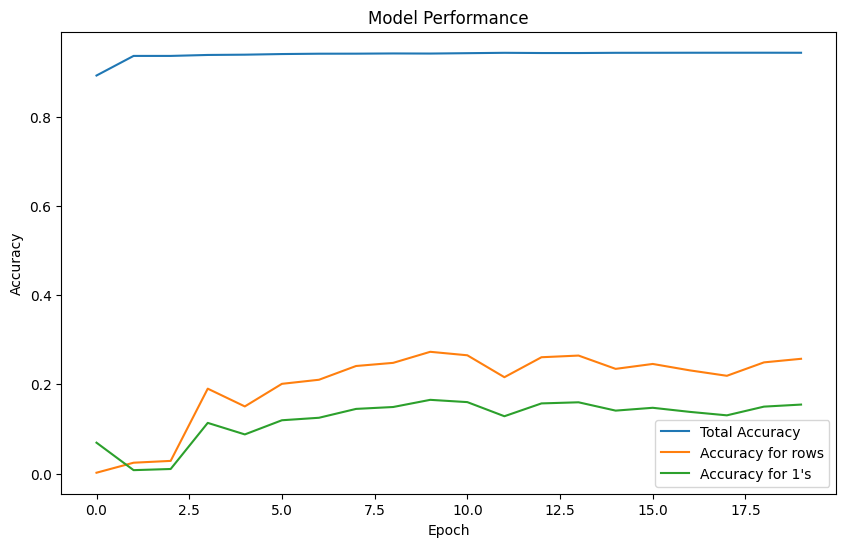

In [ ]:
import matplotlib.pyplot as plt
import csv

# Save the plotted figure as an image file
figure_path = "model_performance.png"
plt.figure(figsize=(10, 6))
plt.plot(test_accuracies, label="Total Accuracy")
plt.plot(equal_row_accuracies, label="Accuracy for rows")
plt.plot(accuracy_ones_list, label="Accuracy for 1's")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Performance")
plt.legend()
plt.savefig(figure_path)
plt.show()

# Save the three lists as a CSV file
csv_path = "model_performance.csv"
with open(csv_path, mode="w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Epoch", "Total Accuracy", "Accuracy for rows", "Accuracy for 1's"])
    for i in range(len(test_accuracies)):
        writer.writerow([i, test_accuracies[i], equal_row_accuracies[i], accuracy_ones_list[i]])


##This is the reuse part of model

In [ ]:
import pandas as pd

# Read the Excel file
file_path = "clean_output.xlsx"
df = pd.read_excel(file_path, engine='openpyxl', header=None)

# Generate the dictionary from the first row, starting from the second column
dictionary = {idx - 1: value for idx, value in enumerate(df.iloc[0, 1:], start=1)}

# Print the dictionary
print(dictionary)


{0: 'Injection site swelling', 1: 'Injection site pain', 2: 'Pyrexia', 3: 'Erythema', 4: 'Pain', 5: 'Pain in extremity', 6: 'Injection site warmth', 7: 'Headache', 8: 'Rash', 9: 'Peripheral swelling', 10: 'Nausea', 11: 'Dizziness', 12: 'Pruritus', 13: 'Skin warm', 14: 'Urticaria', 15: 'Chills', 16: 'Fatigue', 17: 'Vomiting', 18: 'Swelling', 19: 'Injection site pruritus', 20: 'Herpes zoster', 21: 'Myalgia', 22: 'Malaise', 23: 'Asthenia', 24: 'Others'}
